In [17]:
import pandas as pd
import numpy as np

### Loading the data

In [18]:
ratings_df = pd.read_csv('/content/drive/MyDrive/ratings.csv',nrows=1000000)
movies_df = pd.read_csv('/content/drive/MyDrive/movies.csv')

movies_df['movieId'] = movies_df['movieId'].apply(pd.to_numeric)

In [19]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### Creating a user-movie matrix with ratings

In [21]:
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,207367,207405,207642,207830,207890,208002,208080,208737,208793,208939
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Visualization

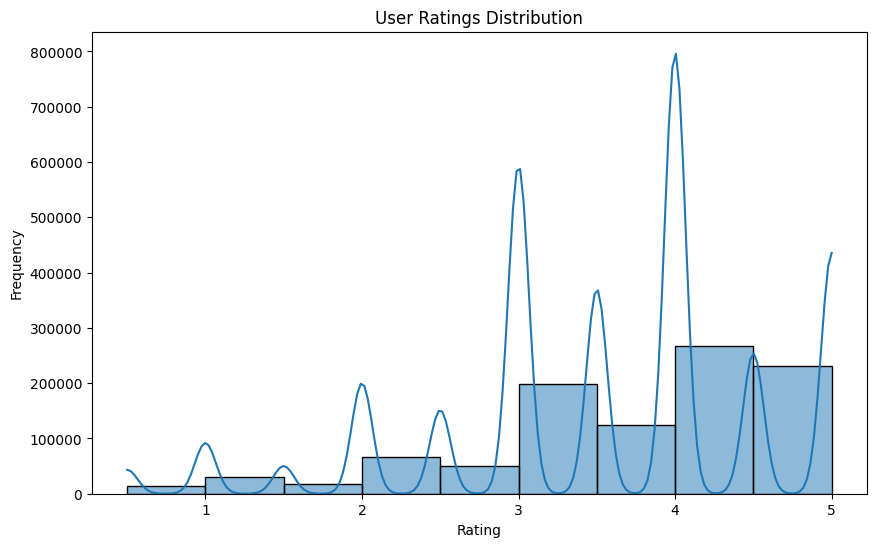

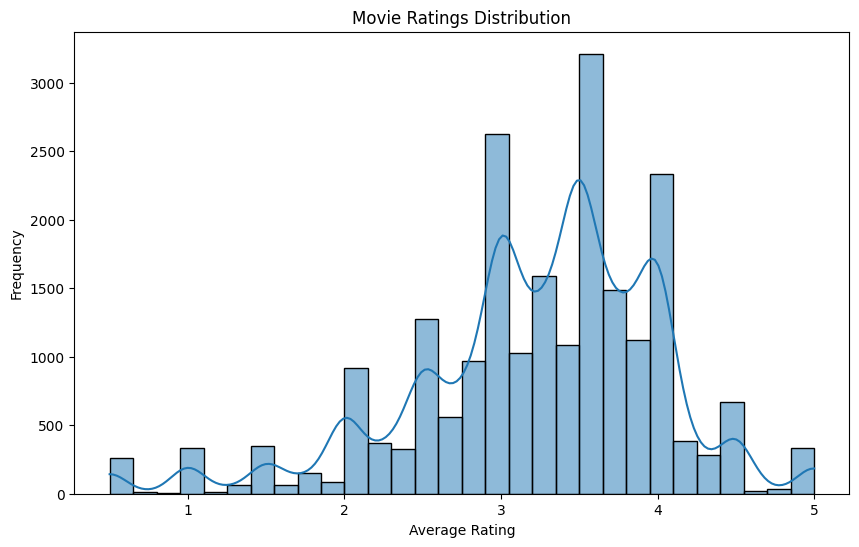

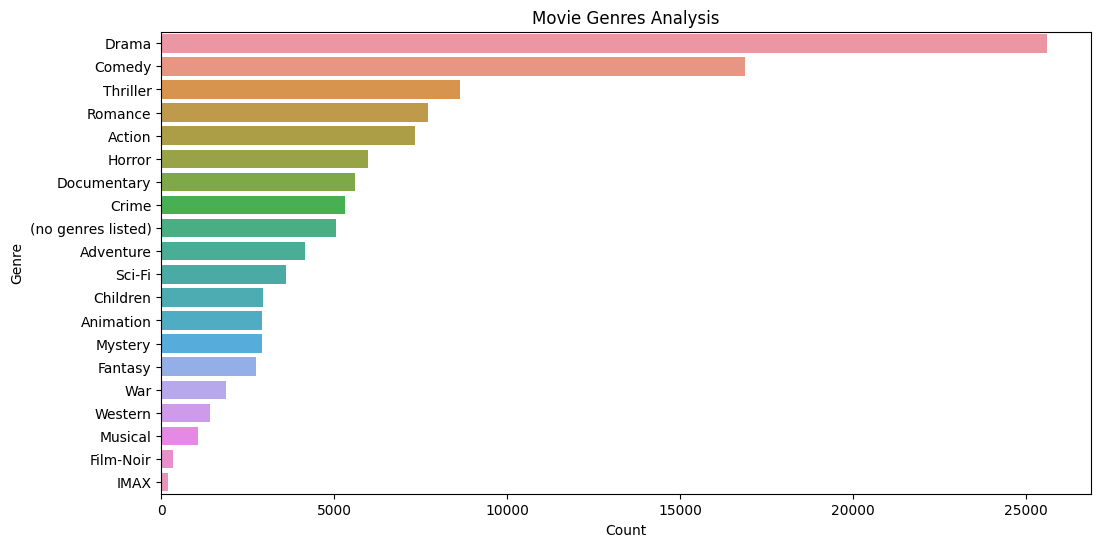

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# User Ratings Distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=9, kde=True)
plt.title('User Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Movie Ratings Distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df.groupby('movieId')['rating'].mean(), bins=30, kde=True)
plt.title('Movie Ratings Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Movie Genres Analysis
genre_counts = movies_df['genres'].str.split('|').explode().value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, orient='h')
plt.title('Movie Genres Analysis')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()



de-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array

In [23]:
R = R_df.to_numpy()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

Using the Scipy function svds because it let’s us choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [24]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

In [25]:
sigma = np.diag(sigma)

### Making Predictions from the Decomposed Matrices

In [26]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)

### Making Movie Recommendations

In [27]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):

    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)

    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations))

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

already_rated, predictions = recommend_movies(preds_df, 75, movies_df, ratings_df, 10)

User 75 has already rated 465 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [28]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
0,75,1,5.0,1537207651,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
111,75,1270,5.0,1537207738,Back to the Future (1985),Adventure|Comedy|Sci-Fi
51,75,595,5.0,1537207824,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
63,75,903,5.0,1537348744,Vertigo (1958),Drama|Mystery|Romance|Thriller
64,75,904,5.0,1537348677,Rear Window (1954),Mystery|Thriller
65,75,908,5.0,1537348713,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller
73,75,1035,5.0,1537348767,"Sound of Music, The (1965)",Musical|Romance
20,75,318,5.0,1537207452,"Shawshank Redemption, The (1994)",Crime|Drama
103,75,1240,5.0,1537207829,"Terminator, The (1984)",Action|Sci-Fi|Thriller
45,75,541,5.0,1537207913,Blade Runner (1982),Action|Sci-Fi|Thriller


In [29]:
predictions

,movieId,title,genres
1156,1307,When Harry Met Sally... (1989),Comedy|Romance
582,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
988,1101,Top Gun (1986),Action|Romance
1087,1219,Psycho (1960),Crime|Horror
830,919,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical
831,920,Gone with the Wind (1939),Drama|Romance|War
29,34,Babe (1995),Children|Drama
11629,56367,Juno (2007),Comedy|Drama|Romance
535,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical
1418,1610,"Hunt for Red October, The (1990)",Action|Adventure|Thriller


In [30]:
#Function to calculate the cosine similarity (sorting by most similar and returning the top N)
def top_cosine_similarity(data, movie_id, top_n=10):
    index = movie_id - 1
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

# Function to print top N similar movies
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
    movie_data[movie_data.movieId == movie_id].title.values))
    for id in top_indexes + 1:
        print((movie_data[movie_data.movieId == id].title.values)[0])

In [31]:
# Function to find movie ID based on movie name
def find_movie_id(movie_data, movie_name):
    movie_id = movie_data[movie_data['title'] == movie_name]['movieId'].values
    if len(movie_id) > 0:
        return movie_id[0]
    else:
        return None

# Function to recommend movies based on movie name
def recommend_similar_movies_by_name(movie_data, movie_name, top_n=10):
    movie_id = find_movie_id(movie_data, movie_name)
    if movie_id is not None:
        sliced = Vt[:, :k]
        indexes = top_cosine_similarity(sliced, movie_id, top_n)
        print_similar_movies(movie_data, movie_id, indexes)
    else:
        print(f"Movie '{movie_name}' not found in the dataset.")

# Example usage

k = 10
movie_name = 'Toy Story (1995)'  # Replace with the movie title you want to base recommendations on
recommend_similar_movies_by_name(movies_df, movie_name, top_n=10)

Recommendations for ['Toy Story (1995)']: 

Toy Story (1995)
Wings of Courage (1995)
Powder (1995)
Ace Ventura: When Nature Calls (1995)
Father of the Bride Part II (1995)
Dead Presidents (1995)
Cutthroat Island (1995)
Sabrina (1995)
Othello (1995)
Usual Suspects, The (1995)
